<a href="https://colab.research.google.com/github/kevincovey/AATau/blob/master/Kevin/notebooks/Segue3_wOrbit%2Buncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*This notebook was originally based on the Gala tutorial at this location: http://gala.adrian.pw/en/latest/dynamics/mockstreams.html*

It has since been heavily modified, to explore the properties of any tidal tails that the Segue 3 stellar cluster might be generating.  Along the way, we've optimized the notebook for the Google Colab environment, including adding a nice 'open in colab' button:





## **(1) Imports**

In [1]:
!apt-get install gsl-bin libgsl0-dev

import sys

import math 

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec

from mpl_toolkits import mplot3d # for 3d plots
import plotly.express as px 

import astropy.units as u
from astropy.table import Table
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord

!pip install gala
import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic

!pip install git+https://github.com/mfouesneau/ezmist
from ezmist import get_one_isochrone

!pip install git+https://github.com/keflavich/imf
import imf
from imf import make_cluster

!pip install corner
import corner

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install astroquery
from astroquery.gaia import Gaia
from astroquery.vizier import Vizier


Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgsl-dev' instead of 'libgsl0-dev'
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgsl23 libgslcblas0
Suggested packages:
  gsl-ref-psdoc | gsl-doc-pdf | gsl-doc-info | gsl-ref-html
The following NEW packages will be installed:
  gsl-bin libgsl-dev libgsl23 libgslcblas0
0 upgraded, 4 newly installed, 0 to remove and 5 not upgraded.
Need to get 1,937 kB of archives.
After this operation, 9,537 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgslcblas0 amd64 2.4+dfsg-6 [79.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgsl23 amd64 2.4+dfsg-6 [823 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 gsl-bin amd64 2.4+dfsg-6 [11.3 kB]
Get:4 htt

## **(2) Segue 3 information**

*Most of the data below was taken from [Hughes et al., 2017](https://ui.adsabs.harvard.edu/abs/2017AJ....154...57H/abstract), [Munoz et al., 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...860...66M/abstract), and [Ortolani, Bica + Barbuy, 2013](https://ui.adsabs.harvard.edu/abs/2013MNRAS.433.1966O/abstract).*

*The proper motions, were extracted from Gaia through this notebook in section (4), and the radial velocity in section (5).*

In [2]:
#measured properties
Segue3_ra = 320.379167*u.degree
Segue3_dec = 19.1172*u.degree
Segue3_dist = (29.1)*u.kpc
Segue3_pm_ra_cosdec = -2.71*u.mas/u.yr
Segue3_pm_dec = -1.78*u.mas/u.yr
Segue3_radial_velocity = -166*u.km/u.s

#physical properties
Segue3_mass = 478 * u.Msun
Segue3_age = 3e9
Segue3_feh = -1.7
Segue3_core_radius = 1*u.pc
Segue3_halo_radius = 2.62*u.pc

## distance modulus assumes a dist in kpc.
Segue3_distMod = 5*math.log10((Segue3_dist.value*1e3)/10.) 
Segue3_angular_radius = (360./(2*3.1415))*Segue3_core_radius.value/(Segue3_dist.value*1e3)


In [3]:
#initialize the coordinate frame
_ = coord.galactocentric_frame_defaults.set('v4.0')

#initialize the coordinate object that describes Segue3 in the current data
Segue3 = coord.SkyCoord(ra=Segue3_ra, dec= Segue3_dec,
                        distance=Segue3_dist,
                        pm_ra_cosdec= Segue3_pm_ra_cosdec,
                        pm_dec= Segue3_pm_dec,
                        radial_velocity=Segue3_radial_velocity)
Segue3_rep = Segue3.transform_to(coord.Galactocentric).data
Segue3_w0 = gd.PhaseSpacePosition(Segue3_rep)

# Choosing either Plummer or Stone potential
#Segue3_pot = gp.PlummerPotential(m=Segue3_mass, b=4*u.pc, units=galactic)
Segue3_pot = gp.StonePotential(m=Segue3_mass, r_c=Segue3_core_radius, r_h=Segue3_halo_radius, units=galactic)

# Choosing the MW potential
mw = gp.MilkyWayPotential()
#mw = gp.BovyMWPotential2014()

df = ms.FardalStreamDF()
gen_Segue3 = ms.MockStreamGenerator(df, mw, progenitor_potential=Segue3_pot)
Segue3_stream, _ = gen_Segue3.run(Segue3_w0, Segue3_mass,
                              dt=-0.5 * u.Myr, n_steps=5200)
Segue3_stream_c = Segue3_stream.to_coord_frame(coord.ICRS)

print(len(Segue3_stream_c))

10402


# **(3) Plots**


## Orbit

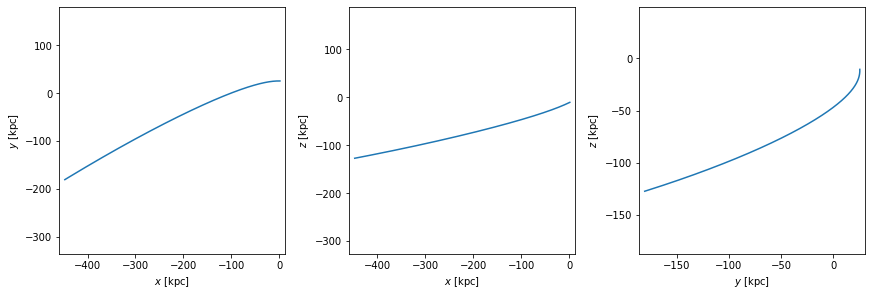

In [9]:
#from all that, it is clear that I first need to make a hamiltonian object from our galactic potential
H = gp.Hamiltonian(mw)

#and then integrate the orbit backwards from NGC6569's current position
# To do this, use the NGC6569_w0 object we created above to define the cluster's 
#position, and then match the timespan to the stream calculation above as well
orbit_Segue3 = H.integrate_orbit(Segue3_w0, dt=-0.5*u.Myr, 
                              t1=2600*u.Myr, t2=0*u.Myr)

#then use the built in method to make plots of the orbit (which outputs twice for reasons I don't understand)
orbit_Segue3.plot()
plt.show()

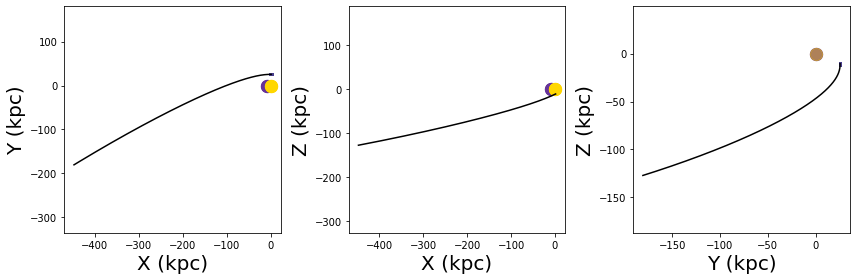

In [14]:
### open a figure with multiple panels (called 'axes')
fig, axes = plt.subplots(1, 3, figsize=(12,4))


### make an XY plot in the first panel / axes[0].  

## Use scatter() to show the tails/stream particles
axes[0].scatter(Segue3_stream.x,
                   Segue3_stream.y, marker='o', s=2, alpha=0.25, color='darkslateblue')

## also use scatter to overlay big dots at the location of the sun and galactic center
axes[0].scatter([-8.1,-8.1], [0,0], marker='o', s=150, alpha=1, color='rebeccapurple')
axes[0].scatter([0,0], [0,0], marker='o', s=150, alpha=1, color='gold')

## finally, show the orbit we just calculated, by using the plot method and specifying 
## the dimensions of interest.
segue3_xyPlot = orbit_Segue3.plot(['x','y'], axes = axes[0], color = 'black')

## add axis labels
axes[0].set_xlabel(r'X (kpc)', fontsize = 20)
axes[0].set_ylabel(r'Y (kpc)', fontsize = 20)


### make an XZ plot in the second panel / axes[1].  

## use scatter() to overlay the stream/tail particles
axes[1].scatter(Segue3_stream.x,
                   Segue3_stream.z, marker='o', s=2, alpha=0.25, color='darkslateblue')

## use scatter() to indicate the location of the Sun & Galactic center
axes[1].scatter([-8.1,-8.1], [0,0], marker='o', s=150, alpha=1, color='rebeccapurple')
axes[1].scatter([0,0], [0,0], marker='o', s=150, alpha=1, color='gold')

## add the orbit to the panel.
segue3_xzPlot = orbit_Segue3.plot(['x', 'z'], axes = axes[1], color = 'black')

## add axis labels
axes[1].set_xlabel(r'X (kpc)', fontsize = 20)
axes[1].set_ylabel(r'Z (kpc)', fontsize = 20)


### make a YZ plot in the second panel / axes[1].  

## use scatter() to overlay the stream/tail particles
axes[2].scatter(Segue3_stream.y,
                   Segue3_stream.z, marker='o', s=2, alpha=0.25, color='darkslateblue')

## use scatter() to indicate the location of the Sun & Galactic center
axes[2].scatter([0,0], [0,0], marker='o', s=150, alpha=0.75, color='rebeccapurple')
axes[2].scatter([0,0], [0,0], marker='o', s=150, alpha=0.25, color='gold')

## add the orbit to the panel.
segue3_xzPlot = orbit_Segue3.plot(['y', 'z'], axes = axes[2], color = 'black')

## add axis labels
axes[2].set_xlabel(r'Y (kpc)', fontsize = 20)
axes[2].set_ylabel(r'Z (kpc)', fontsize = 20)

fig.tight_layout()

In [20]:
## calculate an alternate orbit based on uncertainties in proper motion.
## Looking at Erika's notebook, the 1 sigma uncertainties in our proper motions
## are 0.9 in ra and 0.8 in dec.  Let's decrease both proper motion inputs by
## 1 sigma, in the direction toward 0, and see how that affects the orbits.

## save updated proper motion values
Segue3_alt_pm_ra_cosdec = -1.81*u.mas/u.yr
Segue3_alt_pm_dec = -1.08*u.mas/u.yr

#initialize a new object with the perturbed proper motions
Segue3_alt = coord.SkyCoord(ra=Segue3_ra, dec= Segue3_dec,
                        distance=Segue3_dist,
                        pm_ra_cosdec= Segue3_alt_pm_ra_cosdec,
                        pm_dec= Segue3_alt_pm_dec,
                        radial_velocity=Segue3_radial_velocity)

#represent the object in galactic coordinates, and then in phase space 
Segue3_alt_rep = Segue3_alt.transform_to(coord.Galactocentric).data
Segue3_alt_w0 = gd.PhaseSpacePosition(Segue3_alt_rep)

#now calculate the orbit of this perturbed cluster in a Galactic potential
orbit_Segue3_alt = H.integrate_orbit(Segue3_alt_w0, dt=-0.5*u.Myr, 
                              t1=2600*u.Myr, t2=0*u.Myr)


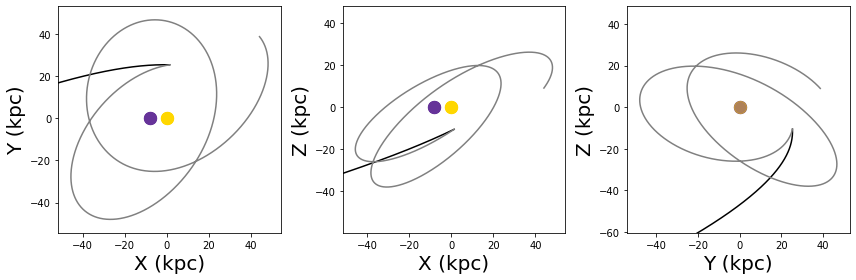

In [21]:
## now remake our orbit figure, adding on our perturbed orbit and removing the
## tails (since they are too small to be seen in this figure).

### open a figure with multiple panels (called 'axes')
fig, axes = plt.subplots(1, 3, figsize=(12,4))


### make an XY plot in the first panel / axes[0].  

## also use scatter to overlay big dots at the location of the sun and galactic center
axes[0].scatter([-8.1,-8.1], [0,0], marker='o', s=150, alpha=1, color='rebeccapurple')
axes[0].scatter([0,0], [0,0], marker='o', s=150, alpha=1, color='gold')

## finally, show the orbit we just calculated, by using the plot method and specifying 
## the dimensions of interest.
segue3_xyPlot = orbit_Segue3.plot(['x','y'], axes = axes[0], color = 'black')
segue3_alt_xyPlot = orbit_Segue3_alt.plot(['x','y'], axes = axes[0], color = 'grey')

## add axis labels
axes[0].set_xlabel(r'X (kpc)', fontsize = 20)
axes[0].set_ylabel(r'Y (kpc)', fontsize = 20)


### make an XZ plot in the second panel / axes[1].  

## use scatter() to indicate the location of the Sun & Galactic center
axes[1].scatter([-8.1,-8.1], [0,0], marker='o', s=150, alpha=1, color='rebeccapurple')
axes[1].scatter([0,0], [0,0], marker='o', s=150, alpha=1, color='gold')

## add the orbit to the panel.
segue3_xzPlot = orbit_Segue3.plot(['x', 'z'], axes = axes[1], color = 'black')
segue3_alt_xzPlot = orbit_Segue3_alt.plot(['x', 'z'], axes = axes[1], color = 'grey')

## add axis labels
axes[1].set_xlabel(r'X (kpc)', fontsize = 20)
axes[1].set_ylabel(r'Z (kpc)', fontsize = 20)


### make a YZ plot in the second panel / axes[1].  

## use scatter() to indicate the location of the Sun & Galactic center
axes[2].scatter([0,0], [0,0], marker='o', s=150, alpha=0.75, color='rebeccapurple')
axes[2].scatter([0,0], [0,0], marker='o', s=150, alpha=0.25, color='gold')

## add the orbit to the panel.
segue3_xzPlot = orbit_Segue3.plot(['y', 'z'], axes = axes[2], color = 'black')
segue3_alt_xzPlot = orbit_Segue3_alt.plot(['y', 'z'], axes = axes[2], color = 'grey')

## add axis labels
axes[2].set_xlabel(r'Y (kpc)', fontsize = 20)
axes[2].set_ylabel(r'Z (kpc)', fontsize = 20)

fig.tight_layout()